In [49]:
import pandas as pd
import numpy as np
import json
import os
import requests
import time
from decimal import getcontext
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import warnings
from uniswapv3_calculator import UniswapV3Calculator
warnings.filterwarnings('ignore')

# Set high precision for accurate calculations
getcontext().prec = 50

In [50]:
# Configuration: List of pools to analyze
POOLS_CONFIG = [
    {
        "pool_addr": "0x5969efdde3cf5c0d9a88ae51e47d721096a97203",
        "token0": "0x2f2a2543b76a4166549f7aab2e75bef0aefc5b0f",  # WBTC
        "token1": "0xfd086bc7cd5c481dcc9c85ebe478a1c0b69fcbb9",  # USDT
        "is_pair_toggled": False,
        "deposit_amount_usd": 100000
    },
    {
        "pool_addr": "0xc6962004f452be9203591991d15f6b388e09e8d0",
        "token0": "0x82af49447d8a07e3bd95bd0d56f35241523fbab1",  # WETH
        "token1": "0xaf88d065e77c8cc2239327c5edb3a432268e5831",  # USDC
        "is_pair_toggled": False,
        "deposit_amount_usd": 100000
    },
    {
        "pool_addr": "0x2f5e87C9312fa29aed5c179E456625D79015299c",
        "token0": "0x2f2a2543B76A4166549F7aaB2e75Bef0aefC5B0f",  # WBTC
        "token1": "0x82af49447d8a07e3bd95bd0d56f35241523fbab1",  # WETH
        "is_pair_toggled": False,
        "deposit_amount_usd": 100000
    },
    {
        "pool_addr": "0x641C00A822e8b671738d32a431a4Fb6074E5c79d",
        "token0": "0x82af49447d8a07e3bd95bd0d56f35241523fbab1",  # WETH
        "token1": "0xfd086bc7cd5c481dcc9c85ebe478a1c0b69fcbb9",  # USDT
        "is_pair_toggled": False,
        "deposit_amount_usd": 100000
    },
    {
        "pool_addr": "0x6f38e884725a116C9C7fBF208e79FE8828a2595F",
        "token0": "0x82af49447d8a07e3bd95bd0d56f35241523fbab1",  # WETH
        "token1": "0xaf88d065e77c8cc2239327c5edb3a432268e5831",  # USDC
        "is_pair_toggled": False,
        "deposit_amount_usd": 100000
    },
    {
        "pool_addr": "0xC6F780497A95e246EB9449f5e4770916DCd6396A",
        "token0": "0x82af49447d8a07e3bd95bd0d56f35241523fbab1",  # WETH
        "token1": "0x912CE59144191C1204E64559FE8253a0e49E6548",  # ARB
        "is_pair_toggled": False,
        "deposit_amount_usd": 100000
    },
    {
        "pool_addr": "0xcDa53B1F66614552F834cEeF361A8D12a0B8DaD8",
        "token0": "0x912CE59144191C1204E64559FE8253a0e49E6548",  # ARB
        "token1": "0xFF970A61A04b1cA14834A43f5dE4533eBDDB5CC8",  # USDC.e
        "is_pair_toggled": False,
        "deposit_amount_usd": 100000
    },
    {
        "pool_addr": "0x50e7B9293aeF80c304234e86C84a01bE8401C530",
        "token0": "0x0c880f6761F1af8d9Aa9C466984b80DAb9a8c9e8",  # PENDLE
        "token1": "0xFd086bC7CD5C481DCC9C85ebE478A1C0b69FCbb9",  # USDC.e
        "is_pair_toggled": False,
        "deposit_amount_usd": 100000
    },
]

# Whether to force fetch data instead of using cache
NO_CACHE = True

# The Graph endpoint for Uniswap V3 on Arbitrum
GRAPH_URL = "https://gateway-arbitrum.network.thegraph.com/api/418eadaa2d81cca124449b86392c8a70/subgraphs/id/FbCGRftH4a3yZugY7TnbYgPJVEv2LvMT6oF1fxPe9aJM"

# Range percentages to test
RANGE_PERCENTAGES = np.arange(0.5, 20.5, 0.5)


In [51]:
def lowercase_addresses(pool_config):
    for entry in pool_config:
        for key in ["pool_addr", "token0", "token1"]:
            if key in entry and isinstance(entry[key], str):
                entry[key] = entry[key].lower()
    return pool_config

POOLS_CONFIG = lowercase_addresses(POOLS_CONFIG)

In [52]:
# Data fetching functions (from notebook 1)
def query_graph(query: str, variables: Dict = None) -> Dict:
    """
    Query The Graph API
    """
    payload = {
        "query": query,
        "variables": variables or {}
    }
    
    try:
        response = requests.post(GRAPH_URL, json=payload, timeout=30)
        response.raise_for_status()
        data = response.json()
        
        if "errors" in data:
            print(f"GraphQL errors: {data['errors']}")
            return {}
            
        return data.get("data", {})
    except Exception as e:
        print(f"Error querying The Graph: {e}")
        return {}

def get_pool_day_data(pool_address: str, num_days: int = 90) -> List[Dict]:
    """
    Get historical pool day data for volume calculation
    """
    query = f"""
    {{
        poolDayDatas(first: {num_days}, orderBy: date, orderDirection: desc, where: {{pool: "{pool_address.lower()}"}}) {{
            date
            volumeUSD
            tvlUSD
            feesUSD
            open
            high
            low
            close
        }}
    }}
    """
    
    result = query_graph(query)
    return result.get("poolDayDatas", [])

def get_pool_ticks(pool_address: str, skip: int = 0, first: int = 1000) -> List[Dict]:
    """
    Get pool ticks data for liquidity calculation
    """
    query = f"""
    {{
        ticks(first: {first}, skip: {skip}, where: {{poolAddress: "{pool_address.lower()}"}}, orderBy: tickIdx) {{
            tickIdx
            liquidityNet
            price0
            price1
        }}
    }}
    """
    
    result = query_graph(query)
    return result.get("ticks", [])

def get_all_pool_ticks(pool_address: str) -> List[Dict]:
    """
    Get all ticks for a pool (paginated)
    """
    all_ticks = []
    skip = 0
    batch_size = 1000
    
    while True:
        ticks = get_pool_ticks(pool_address, skip, batch_size)
        if not ticks:
            break
            
        all_ticks.extend(ticks)
        
        if len(ticks) < batch_size:
            break
            
        skip += batch_size
        time.sleep(0.1)  # Rate limiting
    
    return all_ticks

def get_token_data(token_address: str) -> Dict:
    """
    Get token data including decimals and current price from the Graph API
    """
    query = f"""
    {{
        token(id: "{token_address.lower()}") {{
            id
            name
            symbol
            decimals
            volumeUSD
            totalValueLockedUSD
            tokenDayData(first: 1, orderBy: date, orderDirection: desc) {{
                priceUSD
                date
            }}
        }}
    }}
    """
    
    result = query_graph(query)
    token = result.get("token", {})
    
    # Add priceUSD from the most recent tokenDayData
    if token and 'tokenDayData' in token and token['tokenDayData']:
        token['priceUSD'] = token['tokenDayData'][0]['priceUSD']
        del token['tokenDayData']  # Remove the raw data since we extracted what we need
        
    return token

def sort_tokens(token0_addr: str, token1_addr: str) -> List[str]:
    """
    Sort tokens by address (same as sortTokens in uniswap.ts)
    """
    if token0_addr.lower() < token1_addr.lower():
        return [token0_addr, token1_addr]
    return [token1_addr, token0_addr]

def get_pool_from_pair(token0_addr: str, token1_addr: str) -> List[Dict]:
    """
    Get pool data for a token pair (similar to getPoolFromPair in uniswap.ts)
    """
    sorted_tokens = sort_tokens(token0_addr, token1_addr)
    
    query = f"""
    {{
        pools(orderBy: feeTier, where: {{
            token0: "{sorted_tokens[0].lower()}",
            token1: "{sorted_tokens[1].lower()}"
        }}) {{
            id
            feeTier
            token0 {{
                id
                symbol
            }}
            token1 {{
                id
                symbol
            }}
        }}
    }}
    """
    
    result = query_graph(query)
    return result.get("pools", [])


In [53]:
# Data management functions
def check_data_exists(pool_addr: str) -> Tuple[bool, bool, bool]:
    """
    Check if pool data files exist
    Returns: (pool_day_data_exists, pool_ticks_data_exists, token_data_exists)
    """
    pool_day_exists = os.path.exists(f'{pool_addr}_pool_day_data.csv')
    pool_ticks_exists = os.path.exists(f'{pool_addr}_pool_ticks_data.csv')
    token_data_exists = os.path.exists(f'{pool_addr}_token_data.json')
    
    return pool_day_exists, pool_ticks_exists, token_data_exists

def fetch_and_save_pool_data(pool_config: Dict) -> bool:
    """
    Fetch and save pool data if it doesn't exist
    Returns True if successful, False otherwise
    """
    pool_addr = pool_config['pool_addr']
    token0 = pool_config['token0']
    token1 = pool_config['token1']
    
    try:
        print(f"📥 Fetching data for pool {pool_addr}...")
        
        # Validate pool address
        pools = get_pool_from_pair(token0, token1)
        if not pools:
            print(f"❌ No pools found for token pair {token0} and {token1}")
            return False

        # Find the pool with matching address
        pool_found = False
        for pool in pools:
            if pool['id'].lower() == pool_addr.lower():
                print(f"✅ Valid pool found: {pool['token0']['symbol']}/{pool['token1']['symbol']} (Fee: {int(pool['feeTier'])/1_000_000:.3%})")
                pool_found = True
                break

        if not pool_found:
            available_pools = "\n".join([f"- {p['id']} (Fee: {int(p['feeTier'])/1_000_000:.3%})" for p in pools])
            print(f"❌ Pool address {pool_addr} not found for this token pair.\nAvailable pools:\n{available_pools}")
            return False

        # Get pool data
        pool_day_data = get_pool_day_data(pool_addr, 90)
        pool_ticks_data = get_all_pool_ticks(pool_addr)

        # Get token data
        token0_data = get_token_data(token0)
        token1_data = get_token_data(token1)

        # Save pool data
        df = pd.DataFrame(pool_day_data)
        df.to_csv(f'{pool_addr}_pool_day_data.csv', index=False)

        df = pd.DataFrame(pool_ticks_data)
        df.to_csv(f'{pool_addr}_pool_ticks_data.csv', index=False)

        # Save token data
        token_data = {
            'token0': token0_data,
            'token1': token1_data,
            'pool': {
                'id': pool_addr,
                'feeTier': next(p['feeTier'] for p in pools if p['id'].lower() == pool_addr.lower())
            }
        }
        with open(f'{pool_addr}_token_data.json', 'w') as f:
            json.dump(token_data, f, indent=2)

        print(f"✅ Data saved for pool {pool_addr}")
        return True
        
    except Exception as e:
        print(f"❌ Error fetching data for pool {pool_addr}: {e}")
        return False

def load_pool_data(pool_addr: str) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """
    Load pool data from files
    """
    pool_day_data = pd.read_csv(f'{pool_addr}_pool_day_data.csv')
    pool_ticks_data = pd.read_csv(f'{pool_addr}_pool_ticks_data.csv')
    
    with open(f'{pool_addr}_token_data.json', 'r') as f:
        token_data = json.load(f)
    
    return pool_day_data, pool_ticks_data, token_data


In [54]:
# APR calculation function
def calculate_apr_for_range(pool_config: Dict, range_pct: float, verbose: bool = False) -> Optional[float]:
    """
    Calculate APR for a specific pool and range percentage
    """
    pool_addr = pool_config['pool_addr']
    deposit_amount_usd = pool_config['deposit_amount_usd']
    is_pair_toggled = pool_config['is_pair_toggled']
    
    try:
        # Load data
        pool_day_data, pool_ticks_data, token_data = load_pool_data(pool_addr)
        
        # Set up token decimals and prices
        token0_decimal = int(token_data['token0']['decimals'])
        token1_decimal = int(token_data['token1']['decimals'])

        fee_tier = int(token_data['pool']['feeTier']) / 1_000_000
        
        price_usd_x = float(token_data['token0']['priceUSD'])
        price_usd_y = float(token_data['token1']['priceUSD'])

        # Initialize calculator
        calculator = UniswapV3Calculator(pool_day_data, pool_ticks_data, fee_tier, token0_decimal, token1_decimal, is_pair_toggled)

        if is_pair_toggled:
            P = pool_day_data.iloc[0]['close']
        else:
            P = 1 / pool_day_data.iloc[0]['close']

        range_decimal = range_pct / 100
        Pl = P * (1 - range_decimal)
        Pu = P * (1 + range_decimal)

        in_range = Pl <= P <= Pu
        if not in_range:
            if verbose:
                print(f"❌ Position is out of range for {range_pct}%!")
            return None

        # Calculate token amounts
        amount0, amount1, basic_liquidity_delta = calculator.get_tokens_amount_from_deposit_amount_usd(
            P, Pl, Pu, price_usd_x, price_usd_y, deposit_amount_usd
        )

        # Calculate deltaL
        corrected_delta_l = calculator.calculate_position_liquidity(
            amount0, amount1, Pl, Pu, P
        )

        # Get total liquidity
        current_tick = calculator.get_tick_from_price(P)
        total_liquidity = calculator.get_liquidity_from_tick(current_tick)

        # Calculate fees
        volume_24h = calculator.get_volume_24h_avg()
        estimated_fee_24h = calculator.estimate_fee(corrected_delta_l, abs(total_liquidity), volume_24h)

        yearly_fee = estimated_fee_24h * 365
        yearly_apr_pct = (yearly_fee / deposit_amount_usd) * 100

        return yearly_apr_pct
        
    except Exception as e:
        if verbose:
            print(f"❌ Error calculating APR for pool {pool_addr} at {range_pct}%: {e}")
        return None

def analyze_pool(pool_config: Dict) -> List[Dict]:
    """
    Analyze a single pool across all range percentages
    """
    pool_addr = pool_config['pool_addr']
    results = []
    
    print(f"\n🔄 Analyzing pool {pool_addr}...")
    
    # Check if data exists, if not fetch it
    pool_day_exists, pool_ticks_exists, token_data_exists = check_data_exists(pool_addr)
    
    if NO_CACHE or not (pool_day_exists and pool_ticks_exists and token_data_exists):
        if NO_CACHE:
            print(f"📥 Forcing data fetch (no_cache=True)...")
        else:
            print(f"📥 Data not found, fetching...")
            
        if not fetch_and_save_pool_data(pool_config):
            print(f"❌ Failed to fetch data for pool {pool_addr}")
            return results
    else:
        print(f"✅ Using cached data")
    
    # Load token data for pool info
    try:
        with open(f'{pool_addr}_token_data.json', 'r') as f:
            token_data = json.load(f)
        
        # Create base pool symbol and add fee tier
        base_pool_symbol = f"{token_data['token0']['symbol']}/{token_data['token1']['symbol']}"
        fee_tier_pct = int(token_data['pool']['feeTier']) / 1_000_000
        fee_tier_str = f"{fee_tier_pct:.2%}"
        pool_symbol = f"{base_pool_symbol} ({fee_tier_str})"
        
        print(f"📊 Pool: {pool_symbol}")
        
    except Exception as e:
        print(f"❌ Error loading token data: {e}")
        return results
    
    # Calculate APR for each range
    for range_pct in RANGE_PERCENTAGES:
        apr = calculate_apr_for_range(pool_config, range_pct)
        
        result = {
            'pool_address': pool_addr,
            'pool_symbol': pool_symbol,
            'base_pool_symbol': base_pool_symbol,  # Add base symbol for grouping
            'fee_tier_pct': fee_tier_pct,
            'deposit_amount_usd': pool_config['deposit_amount_usd'],
            'is_pair_toggled': pool_config['is_pair_toggled'],
            'range_percentage': range_pct,
            'apr_percentage': apr
        }
        
        results.append(result)
        
        if apr is not None:
            print(f"  ±{range_pct:4.1f}%: {apr:8.2f}% APR")
        else:
            print(f"  ±{range_pct:4.1f}%: Out of range")
    
    return results


In [55]:
# Main analysis function
def run_multi_pool_analysis():
    """
    Run APR analysis across all configured pools
    """
    print("🚀 Starting Multi-Pool APR Analysis")
    print(f"📊 Analyzing {len(POOLS_CONFIG)} pools")
    print(f"📈 Range: ±{RANGE_PERCENTAGES[0]}% to ±{RANGE_PERCENTAGES[-1]}%")
    print(f"🔢 Total calculations: {len(POOLS_CONFIG) * len(RANGE_PERCENTAGES)}")
    print("=" * 60)
    
    all_results = []
    
    # Analyze each pool
    for i, pool_config in enumerate(POOLS_CONFIG, 1):
        print(f"\n[{i}/{len(POOLS_CONFIG)}] Processing pool {pool_config['pool_addr']}")
        
        pool_results = analyze_pool(pool_config)
        all_results.extend(pool_results)
        
        # Small delay between pools to be nice to the API
        if i < len(POOLS_CONFIG):
            time.sleep(1)
    
    # Convert to DataFrame and save
    results_df = pd.DataFrame(all_results)
    
    # Filter out None values
    results_df = results_df.dropna(subset=['apr_percentage'])
    
    if len(results_df) == 0:
        print("\n❌ No valid results found!")
        return
    
    # Save comprehensive results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"multi_pool_apr_analysis_{timestamp}.csv"
    results_df.to_csv(filename, index=False)
    
    print(f"\n✅ Results saved to {filename}")
    print(f"\n📊 Analysis Summary:")
    print(f"Total valid results: {len(results_df)}")
    print(f"Pools analyzed: {results_df['pool_address'].nunique()}")
    
    return results_df


In [56]:
# Run the analysis
results_df = run_multi_pool_analysis()


🚀 Starting Multi-Pool APR Analysis
📊 Analyzing 8 pools
📈 Range: ±0.5% to ±20.0%
🔢 Total calculations: 320

[1/8] Processing pool 0x5969efdde3cf5c0d9a88ae51e47d721096a97203

🔄 Analyzing pool 0x5969efdde3cf5c0d9a88ae51e47d721096a97203...
📥 Forcing data fetch (no_cache=True)...
📥 Fetching data for pool 0x5969efdde3cf5c0d9a88ae51e47d721096a97203...
✅ Valid pool found: WBTC/USDT (Fee: 0.050%)
✅ Data saved for pool 0x5969efdde3cf5c0d9a88ae51e47d721096a97203
📊 Pool: WBTC/USDT (0.05%)
Current price (token0/token1): 0.000008398137
Current price (token1/token0): 119074.03
deltaL: 5.85e+11
Average 24h volume (last 7 days): $11,231,491.61
  ± 0.5%:   369.50% APR
Current price (token0/token1): 0.000008398137
Current price (token1/token0): 119074.03
deltaL: 2.93e+11
Average 24h volume (last 7 days): $11,231,491.61
  ± 1.0%:   203.27% APR
Current price (token0/token1): 0.000008398137
Current price (token1/token0): 119074.03
deltaL: 1.95e+11
Average 24h volume (last 7 days): $11,231,491.61
  ± 1.5%:  

In [57]:
# Analysis and comparison
if results_df is not None and len(results_df) > 0:
    print("\n🏆 TOP PERFORMERS ANALYSIS")
    print("=" * 50)
    
    # Find best APR for each pool
    best_by_pool = results_df.loc[results_df.groupby('pool_address')['apr_percentage'].idxmax()]
    
    print("\n📈 Best APR per Pool:")
    for _, row in best_by_pool.iterrows():
        print(f"{row['pool_symbol']:20} | ±{row['range_percentage']:4.1f}% | {row['apr_percentage']:8.2f}% APR")
    
    # Overall best performer
    overall_best = results_df.loc[results_df['apr_percentage'].idxmax()]
    print(f"\n🥇 Overall Best:")
    print(f"Pool: {overall_best['pool_symbol']} ({overall_best['pool_address'][:10]}...)")
    print(f"Range: ±{overall_best['range_percentage']}%")
    print(f"APR: {overall_best['apr_percentage']:.2f}%")
    
    # Top 10 results
    print(f"\n🔟 Top 10 Results:")
    top_10 = results_df.nlargest(10, 'apr_percentage')
    for i, (_, row) in enumerate(top_10.iterrows(), 1):
        print(f"{i:2}. {row['pool_symbol']:15} | ±{row['range_percentage']:4.1f}% | {row['apr_percentage']:8.2f}% APR")
    
    # Range analysis
    print(f"\n📊 Range Analysis:")
    range_summary = results_df.groupby('range_percentage')['apr_percentage'].agg(['mean', 'max', 'count']).round(2)
    print(range_summary.head(10))


🏆 TOP PERFORMERS ANALYSIS

📈 Best APR per Pool:
WBTC/WETH (0.05%)    | ± 0.5% |   675.02% APR
PENDLE/USDT (0.30%)  | ± 0.5% |  1221.83% APR
WBTC/USDT (0.05%)    | ± 0.5% |   369.50% APR
WETH/USDT (0.05%)    | ± 0.5% |  1600.46% APR
WETH/USDC (0.01%)    | ± 0.5% |  1077.16% APR
WETH/USDC (0.05%)    | ± 0.5% |  1972.96% APR
WETH/ARB (0.05%)     | ± 0.5% |  1166.82% APR
ARB/USDC (0.05%)     | ± 0.5% |  1138.34% APR

🥇 Overall Best:
Pool: WETH/USDC (0.05%) (0xc6962004...)
Range: ±0.5%
APR: 1972.96%

🔟 Top 10 Results:
 1. WETH/USDC (0.05%) | ± 0.5% |  1972.96% APR
 2. WETH/USDT (0.05%) | ± 0.5% |  1600.46% APR
 3. PENDLE/USDT (0.30%) | ± 0.5% |  1221.83% APR
 4. WETH/ARB (0.05%) | ± 0.5% |  1166.82% APR
 5. ARB/USDC (0.05%) | ± 0.5% |  1138.34% APR
 6. WETH/USDC (0.01%) | ± 0.5% |  1077.16% APR
 7. WETH/USDT (0.05%) | ± 1.0% |  1018.46% APR
 8. WETH/USDC (0.05%) | ± 1.0% |  1017.36% APR
 9. PENDLE/USDT (0.30%) | ± 1.0% |   991.13% APR
10. ARB/USDC (0.05%) | ± 1.0% |   893.87% APR

📊 Range 

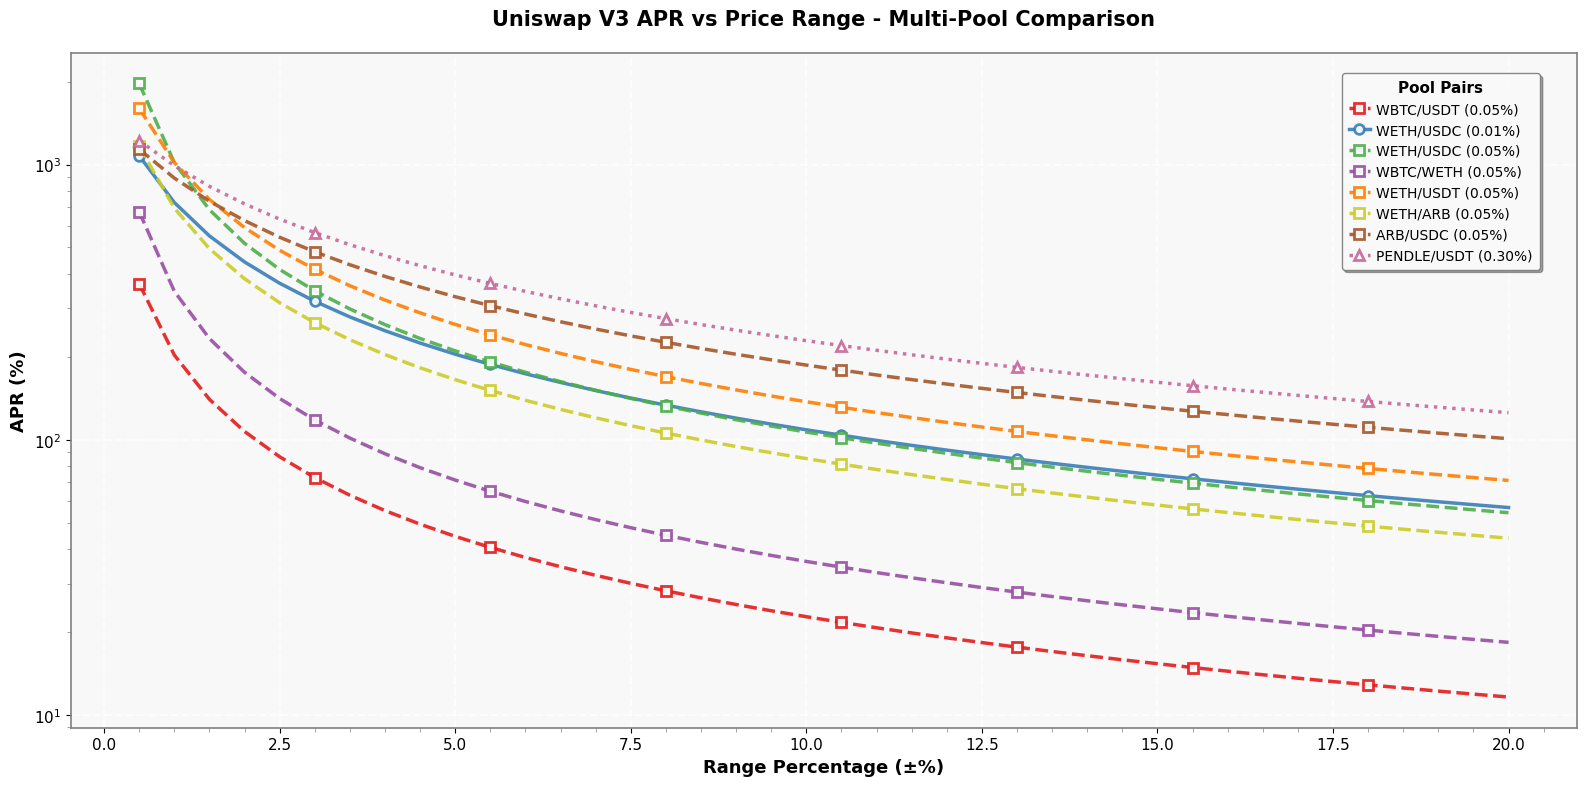

In [60]:
# Visualization (optional)
try:
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import numpy as np
    
    if results_df is not None and len(results_df) > 0:
        # Get unique base pool symbols and fee tiers for color mapping
        base_pools = results_df['base_pool_symbol'].unique()
        fee_tiers = results_df['fee_tier_pct'].unique()
        
        # Generate dynamic colors for each unique combination of pool + fee tier
        # This ensures every line has a distinct color
        pool_fee_combinations = []
        for base_pool in base_pools:
            base_pool_data = results_df[results_df['base_pool_symbol'] == base_pool]
            for fee_tier in sorted(base_pool_data['fee_tier_pct'].unique()):
                pool_fee_combinations.append((base_pool, fee_tier))
        
        # Use a diverse color palette for maximum distinction
        n_combinations = len(pool_fee_combinations)
        
        # Combine multiple colormaps for better color diversity
        colormap1 = plt.cm.Set1
        colormap2 = plt.cm.Dark2
        colormap3 = plt.cm.tab10
        
        combination_colors = {}
        for i, (pool, fee) in enumerate(pool_fee_combinations):
            # Use different colormaps to ensure maximum distinction
            if i < 9:
                color = colormap1(i / 8)
                # Ensure color is dark enough
                rgb = np.array(color[:3])
                while np.mean(rgb) > 0.7:  # If too light
                    rgb = rgb * 0.8  # Darken it
                color = (*rgb, color[3])  # Keep alpha channel
            elif i < 17:
                color = colormap2((i - 9) / 7)
                rgb = np.array(color[:3])
                while np.mean(rgb) > 0.7:
                    rgb = rgb * 0.8
                color = (*rgb, color[3])
            else:
                color = colormap3((i - 17) / 9)
                rgb = np.array(color[:3])
                while np.mean(rgb) > 0.7:
                    rgb = rgb * 0.8
                color = (*rgb, color[3])
            combination_colors[(pool, fee)] = color
        
        # Define line styles and markers for fee tiers
        fee_tier_styles = {
            0.0001: ('-', 'o'),   # Solid line with circle
            0.0005: ('--', 's'),  # Dashed line with square
            0.003: (':', '^'),    # Dotted line with triangle
            0.01: ('-.', 'D')     # Dash-dot line with diamond
        }
        
        # Create figure with optimized size for full width usage
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # Update font sizes for better readability
        plt.rcParams.update({
            'font.size': 11,
            'axes.labelsize': 13,
            'axes.titlesize': 15,
            'xtick.labelsize': 11,
            'ytick.labelsize': 11,
            'legend.fontsize': 10
        })
        
        # Plot each pool with its fee tier
        for base_pool in base_pools:
            base_pool_data = results_df[results_df['base_pool_symbol'] == base_pool]
            
            # Plot each fee tier for this base pool
            for fee_tier in sorted(base_pool_data['fee_tier_pct'].unique()):
                fee_tier_data = base_pool_data[base_pool_data['fee_tier_pct'] == fee_tier]
                
                # Create label with fee tier
                label = f"{base_pool} ({fee_tier:.2%})"
                
                # Get line style and marker for this fee tier
                line_style, marker = fee_tier_styles.get(fee_tier, ('-', 'o'))
                
                # Plot with unique color for each line
                ax.plot(fee_tier_data['range_percentage'], 
                       fee_tier_data['apr_percentage'],
                       linestyle=line_style,
                       marker=marker,
                       color=combination_colors[(base_pool, fee_tier)],
                       label=label,
                       linewidth=2.5,
                       markersize=7,
                       markevery=5,
                       markerfacecolor='white',
                       markeredgewidth=2,
                       alpha=0.9)
        
        # Set labels and title
        ax.set_xlabel('Range Percentage (±%)', fontweight='bold')
        ax.set_ylabel('APR (%)', fontweight='bold')
        ax.set_title('Uniswap V3 APR vs Price Range - Multi-Pool Comparison', 
                    fontweight='bold', pad=20)
        
        # Enhance background and grid
        ax.set_facecolor('#f8f8f8')
        ax.grid(True, linestyle='--', alpha=0.7, color='white', linewidth=1.5)
        ax.set_axisbelow(True)
        
        # Add log scale for y-axis
        ax.set_yscale('log')
        
        # Create floating legend that doesn't interfere with the plot
        # Position it in the upper right corner with some padding
        legend = ax.legend(
            loc='upper right',
            bbox_to_anchor=(0.98, 0.98),
            fontsize=10,
            frameon=True,
            fancybox=True,
            shadow=True,
            framealpha=0.95,
            facecolor='white',
            edgecolor='gray',
            title='Pool Pairs',
            title_fontsize=11,
            borderpad=0.5,
            columnspacing=0.5,
            handlelength=1.5,
            handletextpad=0.5
        )
        
        # Make legend title bold
        legend.get_title().set_fontweight('bold')
        
        # Ensure tight layout to maximize plot area
        plt.tight_layout()
        
        # Optional: Add minor ticks for better readability
        ax.minorticks_on()
        ax.tick_params(which='minor', length=3, width=0.5, color='gray')
        
        # Add subtle border around the plot
        for spine in ax.spines.values():
            spine.set_edgecolor('gray')
            spine.set_linewidth(1.2)
        
        # Show the plot
        plt.show()
        
        # Optional: Save the figure with high DPI for better quality
        # plt.savefig('uniswap_v3_apr_analysis.png', dpi=300, bbox_inches='tight', 
        #             facecolor='white', edgecolor='none')
        
except ImportError:
    print("\n📊 Matplotlib not available for plotting")
except Exception as e:
    print(f"\n❌ Error creating plot: {str(e)}")

In [59]:
# Summary statistics
if results_df is not None and len(results_df) > 0:
    print("\n📈 DETAILED STATISTICS")
    print("=" * 60)
    
    print(f"\nOverall Statistics:")
    print(f"Mean APR: {results_df['apr_percentage'].mean():.2f}%")
    print(f"Median APR: {results_df['apr_percentage'].median():.2f}%")
    print(f"Std Dev: {results_df['apr_percentage'].std():.2f}%")
    print(f"Min APR: {results_df['apr_percentage'].min():.2f}%")
    print(f"Max APR: {results_df['apr_percentage'].max():.2f}%")
    
    # Group by base pool symbol and fee tier
    print(f"\nBy Pool and Fee Tier:")
    pool_fee_stats = results_df.groupby(['base_pool_symbol', 'fee_tier_pct'])['apr_percentage'].agg([
        ('mean', 'mean'),
        ('max', 'max'),
        ('min', 'min'),
        ('count', 'count')
    ]).round(2)
    
    # Format the index for better display
    pool_fee_stats.index = [f"{pool} ({fee:.2%})" for pool, fee in pool_fee_stats.index]
    print(pool_fee_stats)
    
    # Compare fee tiers for each base pool
    print(f"\n📊 Fee Tier Comparison by Pool:")
    for base_pool in results_df['base_pool_symbol'].unique():
        pool_data = results_df[results_df['base_pool_symbol'] == base_pool]
        print(f"\n{base_pool}:")
        for fee_tier in sorted(pool_data['fee_tier_pct'].unique()):
            fee_data = pool_data[pool_data['fee_tier_pct'] == fee_tier]
            max_apr = fee_data['apr_percentage'].max()
            optimal_range = fee_data.loc[fee_data['apr_percentage'].idxmax()]['range_percentage']
            print(f"  {fee_tier:.2%} Fee Tier | Max APR: {max_apr:8.2f}% | Optimal Range: ±{optimal_range:4.1f}%")
    
    print(f"\nBy Range:")
    range_stats = results_df.groupby('range_percentage')['apr_percentage'].agg(['mean', 'max', 'count']).round(2)
    print(range_stats.head(15))
    
    # Find optimal ranges for each pool and fee tier combination
    print(f"\n🎯 Optimal Ranges by Pool and Fee Tier:")
    optimal_ranges = results_df.loc[results_df.groupby(['base_pool_symbol', 'fee_tier_pct'])['apr_percentage'].idxmax()]
    optimal_ranges = optimal_ranges.sort_values(['base_pool_symbol', 'fee_tier_pct'])
    
    for _, row in optimal_ranges.iterrows():
        print(f"{row['base_pool_symbol']} ({row['fee_tier_pct']:.2%}) | "
              f"Optimal: ±{row['range_percentage']:4.1f}% | "
              f"APR: {row['apr_percentage']:8.2f}%")



📈 DETAILED STATISTICS

Overall Statistics:
Mean APR: 191.21%
Median APR: 112.33%
Std Dev: 245.09%
Min APR: 11.61%
Max APR: 1972.96%

By Pool and Fee Tier:
                       mean      max     min  count
ARB/USDC (0.05%)     274.35  1138.34  100.88     40
PENDLE/USDT (0.30%)  323.80  1221.83  125.43     40
WBTC/USDT (0.05%)     45.16   369.50   11.61     40
WBTC/WETH (0.05%)     75.18   675.02   18.35     40
WETH/ARB (0.05%)     160.33  1166.82   43.87     40
WETH/USDC (0.01%)    184.51  1077.16   56.70     40
WETH/USDC (0.05%)    221.14  1972.96   54.29     40
WETH/USDT (0.05%)    245.23  1600.46   71.12     40

📊 Fee Tier Comparison by Pool:

WBTC/USDT:
  0.05% Fee Tier | Max APR:   369.50% | Optimal Range: ± 0.5%

WETH/USDC:
  0.01% Fee Tier | Max APR:  1077.16% | Optimal Range: ± 0.5%
  0.05% Fee Tier | Max APR:  1972.96% | Optimal Range: ± 0.5%

WBTC/WETH:
  0.05% Fee Tier | Max APR:   675.02% | Optimal Range: ± 0.5%

WETH/USDT:
  0.05% Fee Tier | Max APR:  1600.46% | Optimal 